# Many with astrocytes

Let $A_i$ denote an $N_z$ by $N_z$ matrix encoding the synaptic connections controlled by astrocyte $i$.

$$
\begin{eqnarray*}
    \dot{z_i} & = & z_i ( (\lambda_i + \mathrm{i}) + b_i |z_i|^2) + \sum_k W_{ik} z_k \\
    \dot{a_i} & = & \theta \left(\left(\frac{1}{N_a} \sum_k a_k\right) - a_i\right) + \varphi \left( \sum_k B_{ik} |z_k| \right) - \kappa a_i \\
    \dot{W} & = & \alpha\left( I_{N_z} - \mathbf{z} \bar{\mathbf{z}}^\top \right) - \beta\,f\left( \sum_k a_k A^{(k)} \right) \circ W
\end{eqnarray*}
$$

where

$$ f(x) = \frac{\mathrm{e}^\frac{x - x_0}{s}}{1 + \mathrm{e}^\frac{x-x_0}{s}} $$

In [1]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
Nz = 20
Na = 20

# Hopf oscillator characteristics
l = np.random.randn( Nz )
# TODO Should the Lyopunov exponent vary across oscillators?
b = -0.1 + np.random.randn( Nz ) * 1.j

In [21]:
alpha = 0.01 # 0.001 # 0.1
beta = 0.01 # 0.01 # 0.01 # 0.001 # 0.0005 # 0.0001

theta = 1. # 0.00001 # 0.0001
phi = 1.
kappa = 1.

In [4]:
A = []
# for i in range( Na ):
#     A.append( np.random.exponential( size = (Nz, Nz) ) )
for i in range( Na ):
    A_cur = np.zeros( (Nz, Nz) )
    A_cur[i, :] = 1.
    A.append( A_cur )
    
# B = np.zeros( (Na, Nz) )
# for i in range( Na ):
#     for k in range( Nz ):
#         B[i, k] = np.sum( A[i][:, k] )
B = 3 * np.eye( Na )
# B = np.random.exponential( size = (Na, Nz) )

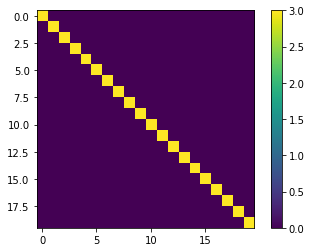

In [5]:
plt.imshow( B )
plt.clim( 0, 3 )
plt.colorbar()

In [6]:
t_input_start = 2e3
t_input_end = 2.1e3 # 2e3 # 1.1e3
input_channel = 10
input_frequency = 1.
input_magnitude = 100.

In [25]:
def sigmoid( x ):
    return np.exp( x ) / (1. + np.exp( x ) )

sigmoid_offset = 4.
sigmoid_scale = 0.25

def deriv( t, y ):
    
    z = y[:Nz]
    a = y[Nz:(Nz+Na)]
    W = np.reshape( y[(Nz+Na):], (Nz, Nz) )
    
    z_dot = np.zeros( z.shape[0], dtype = np.complex )
    for i in range( z_dot.shape[0] ):
        z_dot[i] = z[i] * ( ( l[i] + 1.j ) + b[i] * z[i] * np.conj( z[i] ) )
        
        if t >= t_input_start and t < t_input_end:
            if i == input_channel:
                z_dot[i] = z_dot[i] + input_magnitude * np.sin( 2 * np.pi * input_frequency * t )
        
        for k in range( z_dot.shape[0] ):
#             if k == i:
#                 continue
#             z_dot[i] += W[i, k] * np.real( z[k] )
            z_dot[i] += W[i, k] * z[k]
    
    a_dot = np.zeros( a.shape[0], dtype = np.complex )
    a_bar = (1. / a.shape[0]) * np.sum( a )
    for i in range( a_dot.shape[0] ):
        a_dot[i] = theta * (a_bar - a[i])
        for k in range( z_dot.shape[0] ):
            a_dot[i] += phi * B[i, k] * np.abs( z[k] )
    a_dot -= kappa * a
    
#     W_dot = alpha * ( np.eye( Nz ) - np.outer( np.real( z ), np.real( z ) ) )
    W_dot = alpha * ( np.eye( Nz ) - np.outer( z, np.conj( z ) ) )
#     W_dot = np.zeros( (Nz, Nz), dtype = np.complex )

    if t > 1000.:
        for k in range( a_dot.shape[0] ):
            W_dot -= beta * sigmoid( (a[k] * A[k] - sigmoid_offset) / sigmoid_scale ) * W
    
    y_dot = np.zeros( y.shape[0], dtype = np.complex )
    y_dot[:Nz] = z_dot
    y_dot[Nz:(Nz+Na)] = a_dot
    y_dot[(Nz+Na):] = W_dot.flatten()
    
    return y_dot

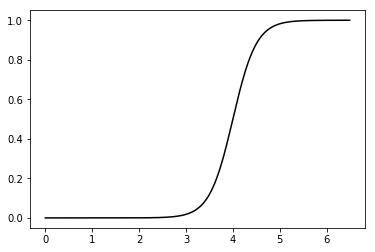

In [26]:
x_test = np.arange( 0., 6.5, 0.01 )
plt.plot( x_test, sigmoid( (x_test - sigmoid_offset) / sigmoid_scale ), 'k-' )

In [9]:
t_span = [0, 4e3]
t_eval = np.arange( t_span[0], t_span[-1], 1e-2 )

In [10]:
# TODO Randomize the z0 in an intelligent way
z0 = np.zeros( (Nz,), dtype = np.complex )
for i in range( z0.shape[0] ):
    z0[i] = 0.01 + 0.j
    
# TODO Randomize the a0 in an intelligent way
a0 = np.random.exponential( size = (Na,) )
    
W0 = np.random.randn( Nz, Nz ) + np.random.randn( Nz, Nz ) * 1.j

In [11]:
y0 = np.zeros( (Nz + Na + Nz*Nz,), dtype = np.complex )
y0[:Nz] = z0
y0[Nz:(Nz+Na)] = a0
y0[(Nz+Na):] = W0.flatten()

In [27]:
sol = scipy.integrate.solve_ivp( deriv, t_span, y0,
                                 t_eval = t_eval )  # 'BDF'

KeyboardInterrupt: 

In [ ]:
t_star = sol.t
y_star = sol.y

z_star = y_star[:Nz, :]
a_star = y_star[Nz:(Nz+Na), :]
W_star = np.reshape( y_star[(Nz+Na):, :], (Nz, Nz, y_star.shape[1]) )

In [ ]:
plt.figure( figsize = (48, 6) )
plt.imshow( np.real( a_star ), aspect = 'auto',
            vmin = np.quantile( np.real( a_star ), 0.01 ),
            vmax = np.quantile( np.real( a_star ), 0.99 ) )

In [ ]:
plt.figure( figsize = (48, 6) )
plt.plot( np.real( a_star ).T )
# plt.ylim( 0, 1. )
plt.show()

In [ ]:
plt.figure( figsize = (48, 6) )
plt.plot( t_star, np.real( a_star[0, :] ), 'r-' )
plt.plot( t_star, np.abs( z_star[0, :] ), 'k-' )
# plt.xlim( 500, 600 )
# plt.ylim( 0, 5 )

In [ ]:
plt.figure( figsize = (48, 6) )
plt.imshow( np.real( z_star ), aspect = 'auto',
            vmin = np.quantile( np.real( z_star ), 0.01 ),
            vmax = np.quantile( np.real( z_star ), 0.99 ) )

In [ ]:
plt.figure( figsize = (48, 6) )
plt.imshow( np.abs( z_star ), aspect = 'auto',
            vmin = 0.,
            vmax = np.quantile( np.abs( z_star ), 0.99 ) )

In [ ]:
plt.figure( figsize = (48, 6) )
plt.plot( np.real( y_star[(Nz+Na):(Nz+Na+50), :] ).T )
plt.show()

MemoryError: Unable to allocate array with shape (400, 400000) and data type float64

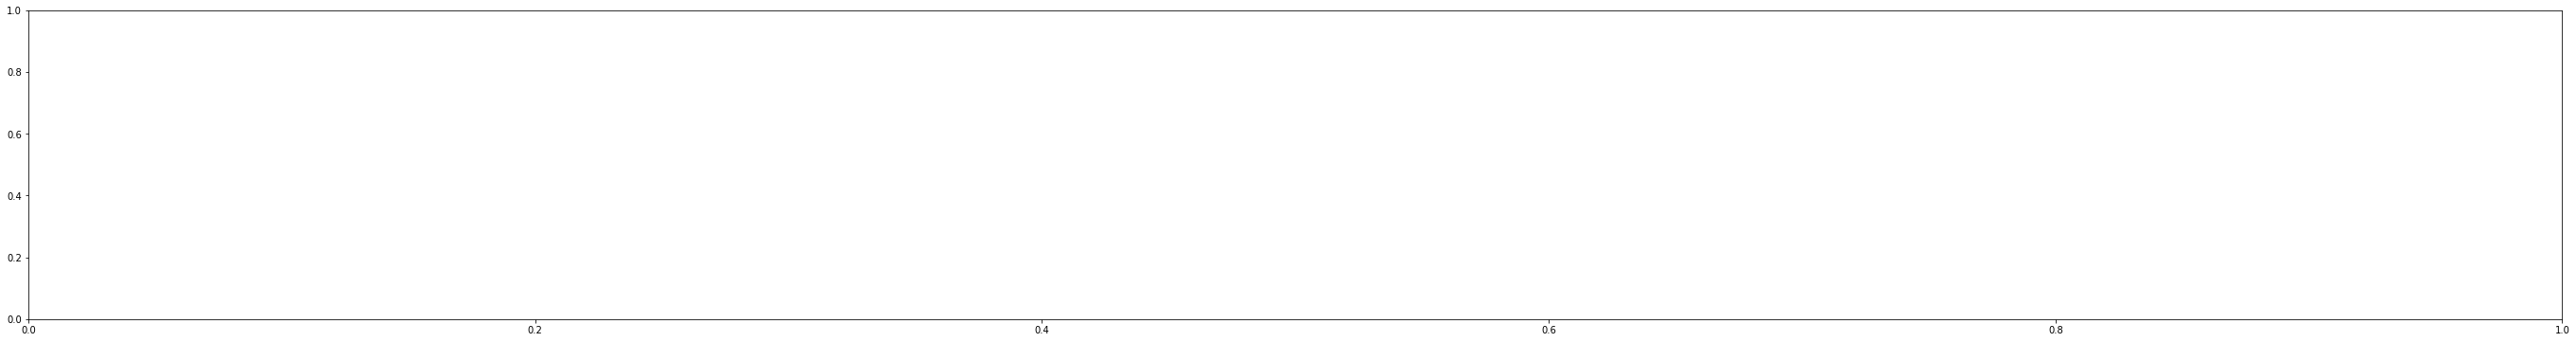

In [20]:
plt.figure( figsize = (48, 6) )
plt.imshow( np.real( y_star[(Nz+Na):, :] ), aspect = 'auto', cmap = 'Spectral_r' )
plt.clim( -1, 1 )
plt.show()

In [ ]:
plt.figure( figsize = (48, 6) )
plt.plot( np.unwrap( np.angle( y_star[(Nz+Na):, :] ) ).T )
plt.show()

In [ ]:
import gc
gc.collect()

In [22]:
import scipy.signal

In [23]:
import concurrent.futures
import time

In [70]:
coherence_window = 512
coherence_window_step = 128
coherence_nfft = 512
coherence_f_min = 0.0
coherence_f_max = 0.1

coherence_starts = np.arange( 0, z_star.shape[1] - coherence_window, coherence_window_step )

In [71]:
def coherence_procedure( i ):
    
    start = time.time()
    
    print( 'Starting row {0}'.format( i ) )
    
    ret = np.zeros( (Nz, coherence_starts.shape[0]) )
    
    for j in range( Nz ):
        for i_start, cur_start in enumerate( coherence_starts ):
            cur_end = cur_start + coherence_window
            cur_data_i = np.real( z_star[i, cur_start:cur_end] )
            cur_data_j = np.real( z_star[j, cur_start:cur_end] )

            f, Cxy = scipy.signal.coherence( cur_data_i, cur_data_j, nfft = coherence_nfft )
            ret[j, i_start] = np.mean( Cxy[(f >= coherence_f_min) & (f < coherence_f_max)] )
    
    end = time.time()
    time_delta = end - start
    
    return ret, time_delta

In [72]:
run_outputs = []
run_times = []

start = time.time()
with concurrent.futures.ProcessPoolExecutor() as executor:
    for cur_output, cur_time in executor.map( coherence_procedure, range( Nz ) ):
        run_outputs.append( cur_output )
        run_times.append( cur_time )
end = time.time()

print( 'Done.' )

Starting row 3
Starting row 4
Starting row 7
Starting row 6
Starting row 5
Starting row 2
Starting row 0
Starting row 1
Starting row 8
Starting row 9
Starting row 10
Starting row 11
Starting row 12
Starting row 13
Starting row 14
Starting row 15
Starting row 16
Starting row 17
Starting row 18
Starting row 19
Done.


In [73]:
print( 'Total execution time: {0:0.3f}'.format( sum( run_times ) ) )
print( 'Total wall time: {0:0.3f}'.format( end - start ) )
print( 'Time saved: {0:0.3f}'.format( sum( run_times ) - (end - start) ) )

Total execution time: 2623.280
Total wall time: 385.705
Time saved: 2237.574


In [74]:
coherence_traces = np.zeros( (Nz, Nz, coherence_starts.shape[0],) )
for i in range( Nz ):
    coherence_traces[i, :, :] = run_outputs[i]

In [75]:
coherence_centers = coherence_starts + coherence_window / 2

In [76]:
coherence_traces_list = []
coherence_pair_list = []
for i in range( Nz ):
    for j in range( i+1, Nz ):
        coherence_traces_list.append( coherence_traces[i, j, :] )
        coherence_pair_list.append( (i, j) )

coherence_traces_linear = np.zeros( (len( coherence_traces_list ), coherence_traces_list[0].shape[0]) )
for i, trace in enumerate( coherence_traces_list ):
    coherence_traces_linear[i, :] = trace

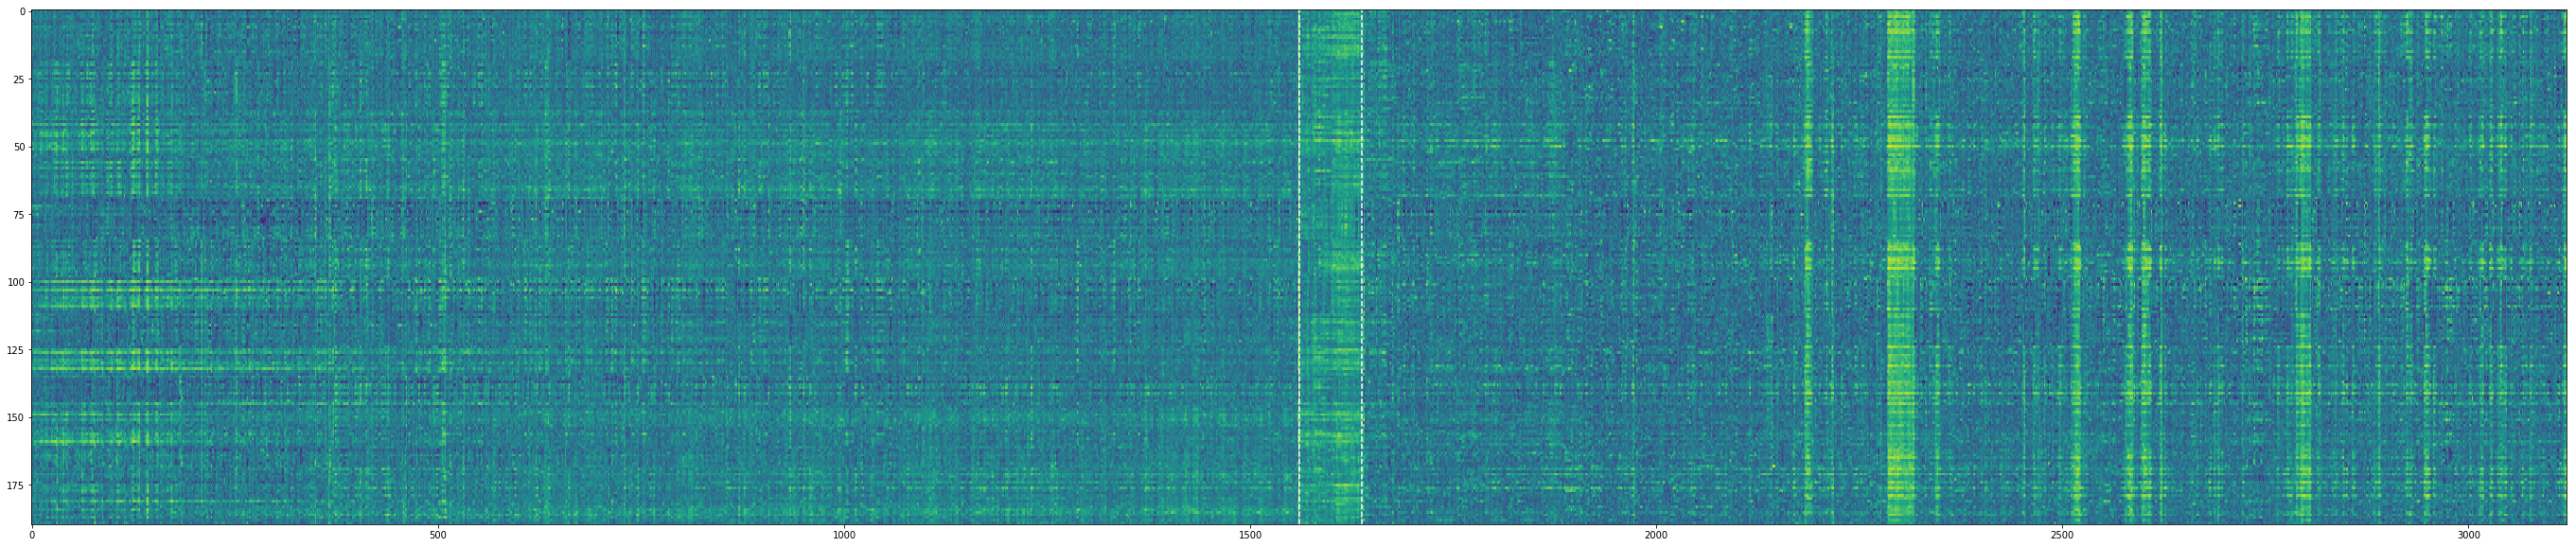

In [77]:
# i_coherence_trunc = np.where( (coherence_centers / 1e2) >= 2000 )[0][0]

plt.figure( figsize = (48, 10) )
plt.imshow( coherence_traces_linear, aspect = 'auto' )

sample_start = np.min( np.where( (coherence_centers / 100) >= t_input_start )[0] )
sample_end = np.max( np.where( (coherence_centers / 100) < t_input_end )[0] )
yl = plt.ylim()
plt.plot( sample_start * np.array( [1, 1] ), yl, 'w--' )
plt.plot( sample_end * np.array( [1, 1] ), yl, 'w--' )

plt.clim( 0, 1 )

In [32]:
import umap

In [33]:
reducer = umap.UMAP()
embedding = reducer.fit_transform( coherence_traces_linear.T )

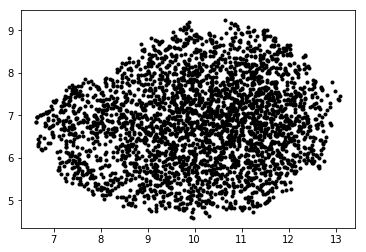

In [34]:
plt.plot( embedding[:, 0], embedding[:, 1], 'k.' )

In [35]:
from sklearn.cluster import AgglomerativeClustering

In [36]:
n_clusters = 10
clustering = AgglomerativeClustering( n_clusters = n_clusters )
coherence_sample_labels = clustering.fit_predict( coherence_traces_linear.T )

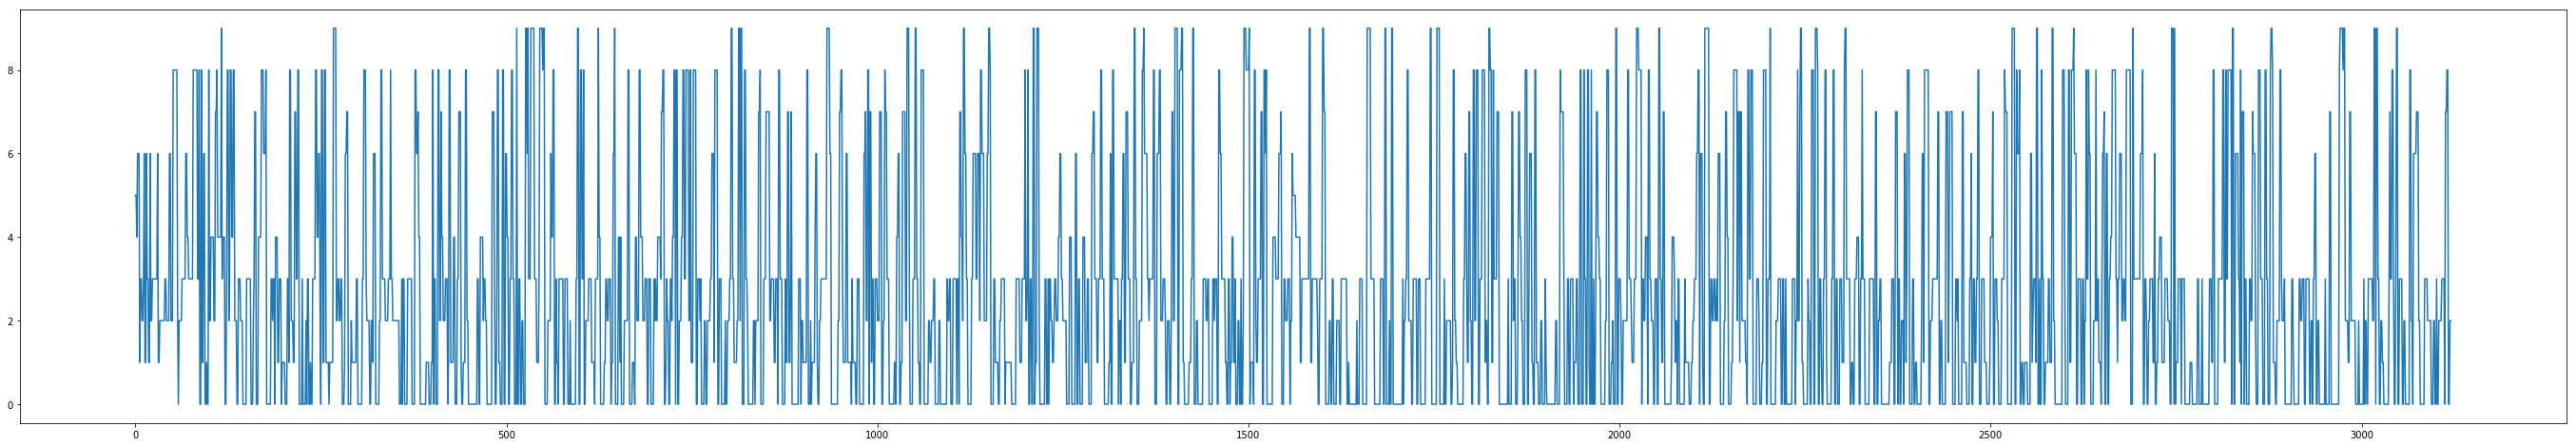

In [37]:
plt.figure( figsize = (48, 8) )
plt.plot( coherence_sample_labels )

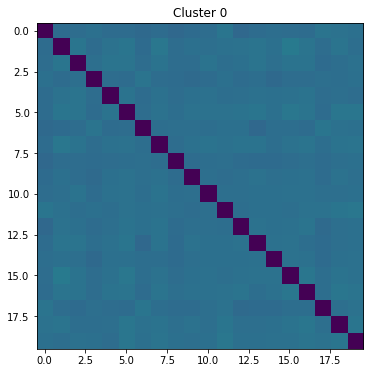

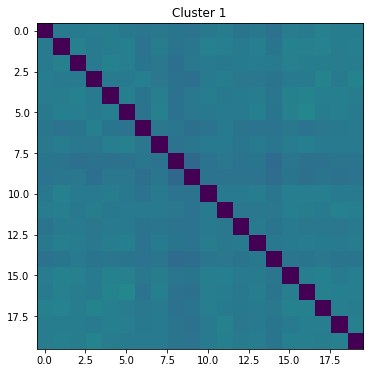

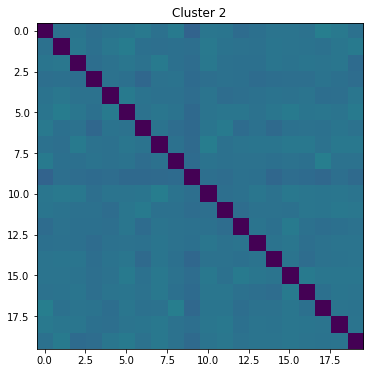

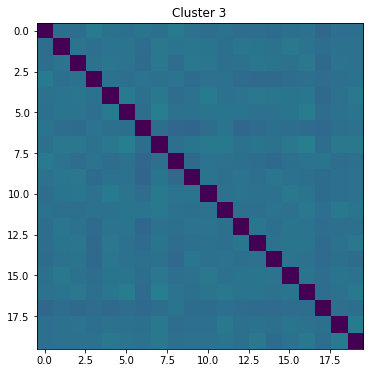

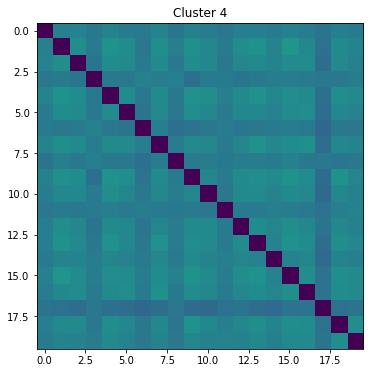

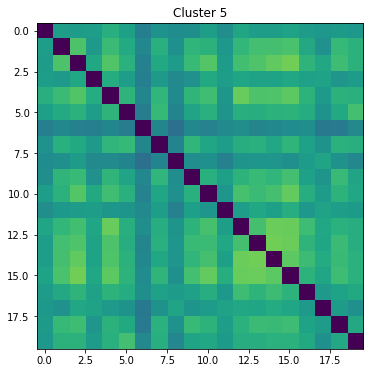

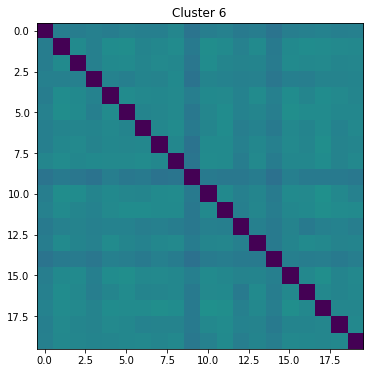

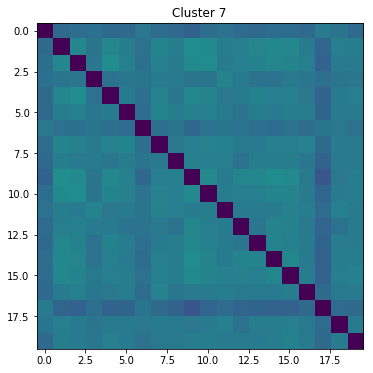

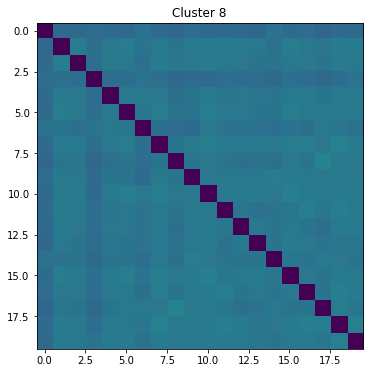

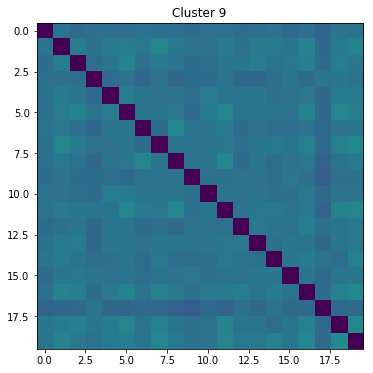

In [38]:
for i_cluster in range( n_clusters ):
    cluster_mean_linear = np.mean( coherence_traces_linear[:, coherence_sample_labels == i_cluster], axis = 1 )
    cluster_mean = np.zeros( (Nz, Nz) )
    for i_pair, pair in enumerate( coherence_pair_list ):
        cluster_mean[pair[0], pair[1]] = cluster_mean_linear[i_pair]
        cluster_mean[pair[1], pair[0]] = cluster_mean_linear[i_pair]
    
    plt.figure( figsize = (6, 6) )
    plt.title( 'Cluster {0}'.format( i_cluster ) )
    plt.imshow( cluster_mean )
    plt.clim( 0, 1 )
    plt.show()

In [39]:
import scipy.spatial

In [40]:
def silhouette_procedure( n_clusters ):
    
    print( 'Testing n_clusters = {0}'.format( n_clusters ) )
    
    start = time.time()
    
    n_samples = coherence_traces_linear.shape[1]
    
#     print( '    Clustering...', end = '' )
    clustering = AgglomerativeClustering( n_clusters = n_clusters )
    coherence_sample_labels = clustering.fit_predict( coherence_traces_linear.T )
#     print( 'Done' )
    
#     print( '    Computing sample distances...', end = '' )
    sample_distances = scipy.spatial.distance_matrix( coherence_traces_linear.T, coherence_traces_linear.T )
#     print( 'Done' )
    
#     print( '    Computing within-cluster distances...' )
    within_distance = np.zeros( (n_samples,) )
    for i_sample in range( n_samples ):
#         if i_sample > 0 and i_sample % 1000 == 0:
#             print( '        Sample {0}'.format( i_sample ) )
        cur_label = coherence_sample_labels[i_sample]
        for j_sample in range( n_samples ):
            if i_sample == j_sample:
                continue
            if coherence_sample_labels[j_sample] != cur_label:
                continue
            within_distance[i_sample] += sample_distances[i_sample, j_sample]
        within_distance[i_sample] *= 1. / (np.sum( coherence_sample_labels == cur_label ) - 1)
#     print( '    Done' )
    
#     print( '    Computing min-without-cluster distances...' )
    min_without_distance = np.zeros( (n_samples,) )
    for i_sample in range( n_samples ):
#         if i_sample > 0 and i_sample % 1000 == 0:
#             print( '        Sample {0}'.format( i_sample ) )
        cur_label = coherence_sample_labels[i_sample]
        without_distances = np.zeros( (n_clusters,) )
        for j_sample in range( n_samples ):
            if i_sample == j_sample:
                continue
            other_label = coherence_sample_labels[j_sample]
            if other_label == cur_label:
                continue
            without_distances[other_label] += sample_distances[i_sample, j_sample]
        for other_label in range( n_clusters ):
            without_distances[other_label] *= 1. / np.sum( coherence_sample_labels == other_label )
        without_distances[cur_label] = np.max( without_distances ) + 1.
        min_without_distance[i_sample] = np.min( without_distances )
#     print( '    Done' )
    
#     print( '    Computing silhouettes...', end = '' )
    silhouette = np.zeros( (n_samples,) )
    total_in_label = [ np.sum( coherence_sample_labels == label ) for label in range( n_clusters )]
    for i_sample in range( n_samples ):
        cur_label = coherence_sample_labels[i_sample]
        if total_in_label[cur_label] == 1:
            silhouette[i_sample] = 0.
            continue
        silhouette[i_sample] = ( min_without_distance[i_sample] - within_distance[i_sample] ) / np.maximum( min_without_distance[i_sample], within_distance[i_sample] )
#     print( 'Done' )
    
    mean_silhouette = np.mean( silhouette )
    print( '    Mean silhouette for {0} clusters = {1}'.format( n_clusters, mean_silhouette ) )
    
    end = time.time()
    time_delta = end - start
    
    return mean_silhouette, time_delta

In [41]:
max_n_clusters = 20

run_outputs = []
run_times = []

start = time.time()
with concurrent.futures.ProcessPoolExecutor() as executor:
    for cur_output, cur_time in executor.map( silhouette_procedure, range( 1, max_n_clusters + 1 ) ):
        run_outputs.append( cur_output )
        run_times.append( cur_time )
end = time.time()

print( 'Done.' )

Testing n_clusters = 7
Testing n_clusters = 5
Testing n_clusters = 4
Testing n_clusters = 6
Testing n_clusters = 8
Testing n_clusters = 2
Testing n_clusters = 3
Testing n_clusters = 1
    Mean silhouette for 1 clusters = -0.58873063188723
Testing n_clusters = 9
    Mean silhouette for 7 clusters = -0.018036123770096356
Testing n_clusters = 10
    Mean silhouette for 2 clusters = 0.014368235018162846
Testing n_clusters = 11
    Mean silhouette for 5 clusters = -0.016496452184261812
Testing n_clusters = 12
    Mean silhouette for 4 clusters = -0.017970358686817327
Testing n_clusters = 13
    Mean silhouette for 3 clusters = -0.006863046877414792
Testing n_clusters = 14
    Mean silhouette for 8 clusters = -0.021794243807999422
Testing n_clusters = 15
    Mean silhouette for 6 clusters = -0.01660366823581064
Testing n_clusters = 16
    Mean silhouette for 9 clusters = -0.020987957630549323
Testing n_clusters = 17
    Mean silhouette for 13 clusters = -0.029034900753844465
Testing n_cluste

In [42]:
print( 'Total execution time: {0:0.3f}'.format( sum( run_times ) ) )
print( 'Total wall time: {0:0.3f}'.format( end - start ) )
print( 'Time saved: {0:0.3f}'.format( sum( run_times ) - (end - start) ) )

Total execution time: 1617.233
Total wall time: 228.927
Time saved: 1388.306


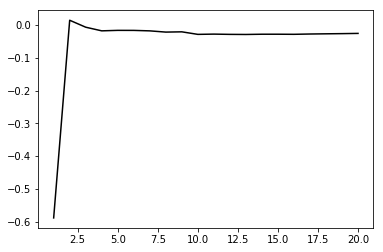

In [43]:
n_clusters_all = np.arange( 1, max_n_clusters + 1 )
mean_silhouette_all = np.array( run_outputs )

plt.plot( n_clusters_all, mean_silhouette_all, 'k-' )

In [44]:
n_clusters = 2
clustering = AgglomerativeClustering( n_clusters = n_clusters )
coherence_sample_labels = clustering.fit_predict( coherence_traces_linear.T )

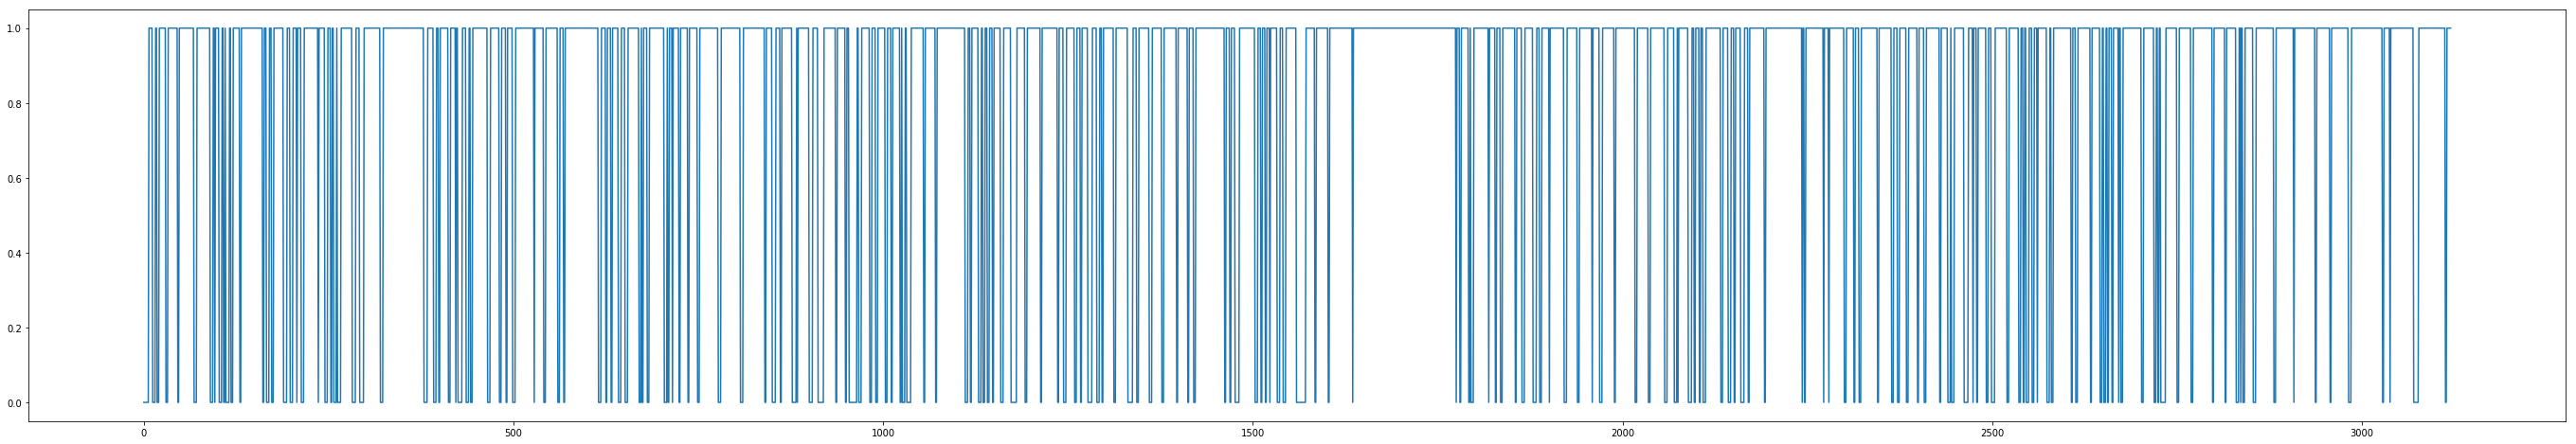

In [45]:
plt.figure( figsize = (48, 8) )
plt.plot( coherence_sample_labels )

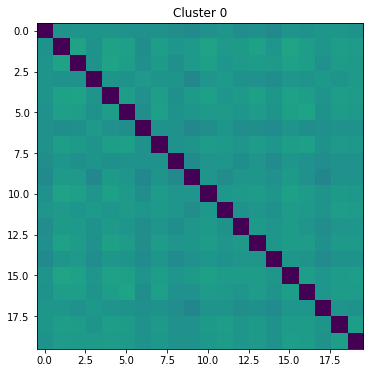

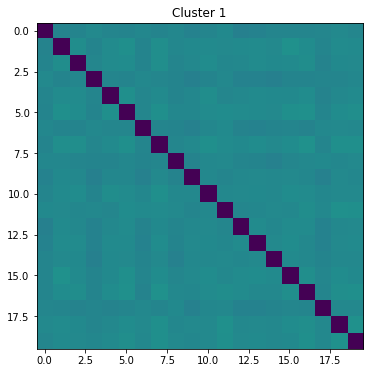

In [49]:
for i_cluster in range( n_clusters ):
    cluster_mean_linear = np.mean( coherence_traces_linear[:, coherence_sample_labels == i_cluster], axis = 1 )
    cluster_mean = np.zeros( (Nz, Nz) )
    for i_pair, pair in enumerate( coherence_pair_list ):
        cluster_mean[pair[0], pair[1]] = cluster_mean_linear[i_pair]
        cluster_mean[pair[1], pair[0]] = cluster_mean_linear[i_pair]
    
    plt.figure( figsize = (6, 6) )
    plt.title( 'Cluster {0}'.format( i_cluster ) )
    plt.imshow( cluster_mean )
    plt.clim( 0, 0.8 )
    plt.show()

In [50]:
import gc

In [51]:
gc.collect()

19180

In [59]:
z_star.shape

(20, 600000)

In [60]:
# TODO Really dumb?
n_in_samples = 100 * 500
z_save = np.zeros( (n_in_samples, z_star.shape[0] * 2) )
for i in range( z_star.shape[0] ):
    z_save[:, 2*i] = np.real( z_star[i, -n_in_samples:] )
    z_save[:, 2*i + 1] = np.imag( z_star[i, -n_in_samples:] )

np.savetxt( 'data/test-run-sm.txt', z_save, delimiter = ',' )